# Assignment 1 _Fingerprint Recognition_

Implement two fingerprint recognition/verification systems.
One key-point based and one (local) image correlation based.

A high-level description will be provided with links to or hints of code snippets and libraries that you can reuse/adapt at your will (with proper referencing!).

The following steps need to be implemented:
1. Importing the required packages
2. Reading image data, conversion to gray-scale
3. Enhancement using orientation/frequency filtering
4. Segmentation of foreground
5. "Minutiae" detection using keypoint detectors and descrptors from OpenCV
6. Matching using keypoint matching
7. Validation using a verification and identification scenario

For steps 1-6, code examples will be provided, that you can adapt at your will (different parameter settings, different choices of alogorithmic components).

# Importing packages
* OpenCV (v3.x)  
* Matplotlib for plotting images and graph  
* Argparse to use command-line parsing   
* Local modules in subdirs  (but can be done where needed)

In [43]:
pwd

'C:\\Users\\Sumi\\Desktop\\NOTES SEM2\\Biometrics System Concepts\\Project\\ASSIGN 1\\AssignmentFPR1'

In [42]:
import cv2
import numpy as np
import argparse
from matplotlib import pyplot as plt
import pathlib as Path
import fprmodules.enhancement as fe
import statistics

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_classification
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score
from sklearn.metrics import auc
from sklearn.metrics import average_precision_score

from itertools import cycle
from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from scipy import interp

%matplotlib inline 

## Function Definitions

In [40]:
def SimpleDatasetLoader(imagePaths):
    # initialize the list of features and labels
    data = []
    labels = []

    # loop over the input images
    for imagePath in imagePaths:
        image = cv2.imread(str(imagePath), cv2.IMREAD_GRAYSCALE)
        height, width = image.shape
        label = imagePath.name
        # treat our processed image as a "feature vector"
        # by updating the data list followed by the labels
        data.append(image.flatten())
        labels.append(label)
    # return a tuple of the data and labels
    return (np.array(data), np.array(labels),height, width)


def labels_to_class(labels):
    class_labels = np.empty(len(labels))
    for i in range(len(labels)):
        class_labels[i] = labels[i].split("_")[0]
    # encode the labels as integers
    le = LabelEncoder()
    class_labels = le.fit_transform(class_labels)
    return class_labels


### Defining parameters

In [41]:
# from pathlib import Path

# # load the dataset from disk and reshape the data matrix (images flattened)
# datasetPath_arr = []
# enh_datasetPath_arr = []
# # imagePaths_arr = []
# data_arr = []
# labels_arr = []
# class_labels_arr = []
# height_arr = []
# width_arr = []

# for i in range(4):
#     datasetPath_arr.append(Path('C:/Users/Sumi/Desktop/NOTES SEM2/Biometrics System Concepts/Project/ASSIGN 1/AssignmentFPR1/fprdata/DB'+str(i+1)+'_B'))
#     enh_datasetPath_arr.append('C:/Users/Sumi/Desktop/NOTES SEM2/Biometrics System Concepts/Project/ASSIGN 1/AssignmentFPR1/fprdata/enh_DB'+str(i+1)+'_B')
#    # imagePaths_arr.append = datasetPath_arr[i].rglob("*.tif")
#     data, labels, height, width = SimpleDatasetLoader(datasetPath_arr[i].rglob("*.tif"))
#     data_arr.append(data)
#     labels_arr.append(labels)
#     height_arr.append(height)
#     width_arr.append(width)
#     cl = labels_to_class(labels)
#     class_labels_arr.append(cl)  

## Enhancement using ridge orientation and frequency estimation

We will re-use code developed by [Utkarsh Deshmukh][https://github.com/Utkarsh-Deshmukh/Fingerprint-Enhancement-Python], which is a Python-recode of Matlab-code developed by [Peter Kovesi][https://www.peterkovesi.com/matlabfns/index.html#fingerprints] which I have slightly adapted to make more compliant with OpenCV. It uses gradient-based orientation and local frequency estimation as input to an orientation and frequency selective filtering using a Gabor filterbank. At the same time a foreground region segmentation (mask) is determined by calculating the standard deviation in local windows and thresholding above a certain level. 

In [6]:
def enhancement(img_1): #img_2
    # frequency and orientation selective filtering/enhancement
    img_e_1, mask1, orientim1, freqim1 = fe.image_enhance(img_1);  
    #img_e_2, mask2, orientim2, freqim2 = fe.image_enhance(img_2);     

    # normalize the floating point values to a uint8 range
    img_e_u_1 = cv2.normalize(img_e_1, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=0 )
    #img_e_u_2 = cv2.normalize(img_e_2, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=0 )   
    
    return img_e_u_1 #,img_e_u_2

## Run to Store enhanced images -- DONE


In [10]:
# # Choosing a particular dataset [0,1,2,3] for Image enhancement
# # n=0

# datasetPath = datasetPath_arr[n]
# dataset=data_arr[n].copy()
# labels = labels_arr[n]
# class_labels = class_labels_arr[n]
# height = height_arr[n]
# width = width_arr[n]
# enh_datasetPath = enh_datasetPath_arr[n]
# # print(labels,datasetPath,enh_datasetPath, class_labels)

# # Run to Store enhanced images -- DONE

# for i in range(dataset.shape[0]):
#     img = np.reshape(dataset[i], (height, width))
#     e_img = enhancement(img)
#     cv2.imwrite(enh_datasetPath+"/"+labels[i],e_img)


## Minutiae Extraction and matching
The basis FPR matching is based on matching keypoints, called minutiae. They are defined as the ridge endings and bifurcations and can be easily determined by first thresholding and skeletonizing/thinning the enhanced image.  
Instead, we will rely on the developments in Computer Visions, where the use of keypoint features turned out to be very succesfull. 
In this first assignment, you are encouraged to tray out a series of detection/description/matching algorithms as presented in (at a relatively descriptive level) [keypoint_detection_descrption_matching][https://docs.opencv.org/3.0-beta/doc/py_tutorials/py_feature2d/py_table_of_contents_feature2d/py_table_of_contents_feature2d.html#py-table-of-content-feature2d] (it is a nice presentation, but I apologize for the louzy language).
Please read these pages carefully. 
Below, you find one example, that uses ORB features. 
You can experiment with other feature descriptors and matching routines as presented on these pages.

In [31]:
def matching_ORB(img_e_u_1,img_e_u_2):
    
    MAX_FEATURES = 500

    # Initiate ORB detector
    orb = cv2.ORB_create(MAX_FEATURES)

    # find the keypoints and descriptors with SIFT
    kp1, des1 = orb.detectAndCompute(img_e_u_1,None)
    kp2, des2 = orb.detectAndCompute(img_e_u_2,None)

    bf = cv2.BFMatcher(cv2.NORM_HAMMING2, crossCheck=True)

    matches = bf.match(des1,des2)

    # sort matches based on feature distance
    # matches = sorted(matches, key=lambda x: x.distance)
    matches.sort(key=lambda x: x.distance, reverse=False)

    # Draw top 10 matches
    imMatches = cv2.drawMatches(img_e_u_1,kp1,img_e_u_2,kp2,matches[:10], None) #, flags=2)

#     plt.imshow(imMatches),plt.show()
    return kp1, kp2, matches

In [32]:
def find_distance(matches):
    dist = []
    for i in range(len(matches)):
        dist.append(matches[i].distance)
    mid_dist = statistics.median(dist)
    return mid_dist

def good_matches(matches):
    GOOD_MATCH_PERCENT = 0.25
    # Remove not so good matches
    numGoodMatches = int(len(matches) * GOOD_MATCH_PERCENT)
    matches = matches[:numGoodMatches]
    return matches

## Apply homography
[Following]{https://www.learnopencv.com/image-alignment-feature-based-using-opencv-c-python/] estimate the homography based on the best matches. Using RANSAC you can estimate this transformation in a robust way, taking into account outliers.

In [33]:
def apply_homography(kp1, kp2, img_1, img_2, matches):
    src_pts = np.float32([ kp1[m.queryIdx].pt for m in matches ]).reshape(-1,1,2)
    dst_pts = np.float32([ kp2[m.trainIdx].pt for m in matches ]).reshape(-1,1,2)

    M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC,5.0)

    # Use homography
    height, width = img_2.shape[:2]
    im1_homo = cv2.warpPerspective(img_1, M, (width, height))

    return im1_homo, img_2


## MAIN

In [34]:
from pathlib import Path
n=1 #1, 2, 3

datasetPath = datasetPath_arr[n]
dataset=data_arr[n].copy()
labels = labels_arr[n]
class_labels = class_labels_arr[n]
height = height_arr[n]
width = width_arr[n]

# Enhanced images for n=1,2,3
enh_datasetPath = Path(enh_datasetPath_arr[n])
dataset_enh, labels_enh, height_enh, width_enh = SimpleDatasetLoader(enh_datasetPath.rglob("*.tif"))

# print(dataset_enh.shape, labels_enh.shape, height_enh, width_enh)
##(80, 165760) (80,) 560 296

In [37]:
#Getting Gallary and Query sets forCMC curve
G = [] #Gallary set --10 images (for 10 persons, 1 image of each)
Q = [] #Query set -- rest 70 images (for 10 persons, 7 images of each)
S_scores = np.empty((70, 10))

#1st image out of every 8 images of a person is kept in Gallery, rest goes to Query set
for i in range(dataset_enh.shape[0]):
    if (i % 8 == 0):
        G.append(dataset_enh[i])
    else:
        Q.append(dataset_enh[i])

labels_G = [0,1,2,3,4,5,6,7,8,9]

for i in range(len(Q)):
    Q_img = Q[i]
    Q_image = np.reshape(Q_img, (height_enh, width_enh))
    for j in range(len(G)):
        G_img = G[j]
        G_image = np.reshape(G_img, (height_enh, width_enh))
        k1, k2, m = matching_ORB(Q_image,G_image)
        # Applying homography to the enhanced images
        enh_img1_homo, enh_img_2 = apply_homography(enh_kp1, enh_kp2, enh_img_1, enh_img_2, enh_matches)        
        kp1_aft_homo, kp2_aft_homo, matches_aft_homo = matching_ORB(enh_img1_homo,enh_img_2)
        matches = good_matches(matches)
        enh_matches = good_matches(enh_matches)
        matches_aft_homo = good_matches(matches_aft_homo)
        S_scores[i][j] = find_distance(m)

NameError: name 'matches' is not defined

In [23]:
predictions = np.random.randint(10, size=(100,20))
labels = np.random.randint(10,size=100)
ranks = np.zeros(len(labels))

# for i in range(len(labels)) :
i=1
# print (predictions[i])
# print (labels)
if labels[i] in predictions[i] :
    firstOccurance = np.argmax(predictions[i]== labels[i])   
#     print(firstOccurance)
    for j in range(firstOccurance, len(labels)) :            
        ranks[j] +=1

# print (ranks)
cmcScores = [float(i)/float(len(labels)) for i in ranks]
# print (cmcScores, len(cmcScores))

## Plot Images - Original vs Enchanced !!       

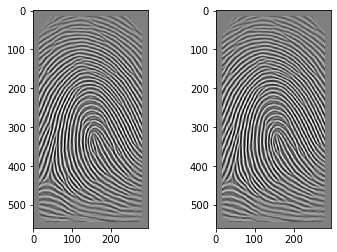

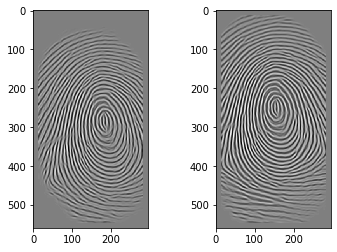

In [25]:
# Plot any 2 individual images
image1_name = Q[7]
image2_name = dataset_enh[9]
fig = plt.figure()
plt.subplot(1,2,1)
plot_gray_img(image1_name,height,width)
plt.subplot(1,2,2)
plot_gray_img(image2_name,height,width)

np.random.seed(40)

# Plot 2 individual Enhanced images
enh_image1_name = dataset_enh[0]
enh_image2_name = dataset_enh[1]
enh_img_1 = np.reshape(enh_image1_name, (height_enh, width_enh))
enh_img_2 = np.reshape(enh_image2_name, (height_enh, width_enh))

fig = plt.figure()
plt.subplot(1,2,1)
plot_gray_img(enh_image1_name,height_enh,width_enh)
plt.subplot(1,2,2)
plot_gray_img(enh_image2_name,height_enh,width_enh)

enh_kp1, enh_kp2, enh_matches = matching_ORB(enh_img_1,enh_img_2)
# Applying homography to the enhanced images
enh_img1_homo, enh_img_2 = apply_homography(enh_kp1, enh_kp2, enh_img_1, enh_img_2, enh_matches)        
kp1_aft_homo, kp2_aft_homo, matches_aft_homo = matching_ORB(enh_img1_homo,enh_img_2)


## Distance Calculation for Original, Enhanced, Enhanced Homography Matrices and Storing Flattened Matrices     -- DONE

In [38]:
# dist_matrix = np.empty((mat_size, mat_size))
# enh_dist_matrix = np.empty((mat_size, mat_size))
# homo_dist_matrix = np.empty((mat_size, mat_size))
outPath = './fprdata/Output Files/' #To save the distance matrices obtained

# for i in range(mat_size):
# #     image1_name = dataset[i]
#     enh_image1_name = dataset_enh[i]
# #     print("i=",i)
# #     img_1 = np.reshape(image1_name, (height, width))
#     enh_img_1 = np.reshape(enh_image1_name, (height_enh, width_enh))
    
#     for j in range(mat_size):
# #         image2_name = dataset[j]
#         enh_image2_name = dataset_enh[j]
    
# #         img_2 = np.reshape(image2_name, (height, width))
#         enh_img_2 = np.reshape(enh_image2_name, (height_enh, width_enh))

# #         kp1, kp2, matches = matching_ORB(img_1,img_2)
#         enh_kp1, enh_kp2, enh_matches = matching_ORB(enh_img_1,enh_img_2)
#         # Applying homography to the enhanced images
#         enh_img1_homo, enh_img_2 = apply_homography(enh_kp1, enh_kp2, enh_img_1, enh_img_2, enh_matches)        
#         kp1_aft_homo, kp2_aft_homo, matches_aft_homo = matching_ORB(enh_img1_homo,enh_img_2)

# #         matches = good_matches(matches)
# #         enh_matches = good_matches(enh_matches)
#         matches_aft_homo = good_matches(matches_aft_homo)
        
# #         dist_matrix[i][j] = find_distance(matches)
# #         enh_dist_matrix[i][j] = find_distance(enh_matches)
#         homo_dist_matrix[i][j] = find_distance(matches_aft_homo)

# # dist_matrix_f = dist_matrix.flatten()
# enh_dist_matrix_f = enh_dist_matrix.flatten()
# homo_dist_matrix_f = homo_dist_matrix.flatten()

# # outfile = outPath+'/Orig_distMat_DB_'+str(n+1)
# # outfile = outPath+'/Enhanced_distMat_DB_'+str(n+1)
# outfile = outPath+'/Homography_distMat_DB_'+str(n+1)

# # np.save(outfile,dist_matrix_f)
# # np.save(outfile,enh_dist_matrix_f)
# np.save(outfile,homo_dist_matrix_f)

# # np.load(outfile+'.npy')


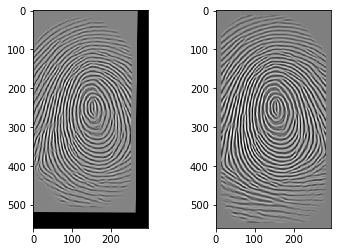

In [39]:
# Plot 2 individual Homography images
enh_image1_name = enh_img1_homo
enh_image2_name = enh_img_2
fig = plt.figure()
plt.subplot(1,2,1)
plot_gray_img(enh_image1_name,height_enh,width_enh)
plt.subplot(1,2,2)
plot_gray_img(enh_image2_name,height_enh,width_enh)

## Determine matching function
Determine a matching function based on the results obtained above
* a function of the feature distances (sum or number of matching features below distance threshold)
* a function of the number of features within a spatial distance (before and after homography)
* any other combination

In [27]:
mat_size = dataset.shape[0]
# Matching Function
check_matching = np.zeros((mat_size, mat_size))

for i in range(mat_size):
    for j in range(mat_size):
        if(class_labels[i] == class_labels[j]):
            check_matching[i][j] = 1
        
check_matching_f = check_matching.flatten()


## Plotting ROC Curve - For verification scenario

Reference

https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html#sphx-glr-auto-examples-model-selection-plot-roc-py

https://stackoverflow.com/questions/28339746/equal-error-rate-in-python

https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html

In [29]:
x=4 #2,3,4
# Compute ROC curve and ROC area for each class
y_test = check_matching_f
y_score_orig = np.load(outPath+'Orig_distMat_DB_'+str(x)+'.npy')
y_score_enh = np.load(outPath+'Enhanced_distMat_DB_'+str(x)+'.npy')
y_score_homo = np.load(outPath+'Homography_distMat_DB_'+str(x)+'.npy')

y_score_orig = cv2.normalize(y_score_orig, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX)
y_score_orig = 1-y_score_orig

y_score_enh = cv2.normalize(y_score_enh, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX)
y_score_enh = 1-y_score_enh

y_score_homo = cv2.normalize(y_score_homo, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX)
y_score_homo = 1-y_score_homo

fpr = dict()         #False positive rate
tpr = dict()         #True positive rate
fnr = dict()         #False negative rate
roc_auc = dict()     #Area under curve for ROC


NameError: name 'outPath' is not defined

In [102]:
y_score_orig.shape

(6400, 1)

In [1]:
def compute_roc_EER(fpr, tpr):
    roc_EER = []
    cords = zip(fpr, tpr)
    for item in cords:
        item_fpr, item_tpr = item
        if item_tpr + item_fpr == 1.0:
            roc_EER.append((item_fpr, item_tpr))
assert(len(roc_EER) == 1.0)
return np.array(roc_EER)



NameError: name 'roc_EER' is not defined

In [2]:
from sklearn.metrics import roc_curve, auc

i = "orig_key"
j = "enh_key"
k = "homo_key"

fpr[i], tpr[i], thresh_orig = roc_curve(y_test, y_score_orig)
fnr[i] = 1 - tpr[i]
roc_auc[i] = auc(fpr[i], tpr[i])
eer_threshold[i] = thresh_orig(np.nanargmin(np.absolute((fnr[i] - fpr[i]))))
print(eer_threshold[i])

fpr[j], tpr[j], thresh_enh = roc_curve(y_test, y_score_enh)
fnr[j] = 1 - tpr[j]
roc_auc[j] = auc(fpr[j], tpr[j])

fpr[k], tpr[k], thresh_homo = roc_curve(y_test, y_score_homo)
fnr[k] = 1 - tpr[k]
roc_auc[k] = auc(fpr[k], tpr[k])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], thresh_orig = roc_curve(y_test.ravel(), y_score_orig.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])


print("Area under ROC Curve Orig : ", roc_auc[i])
print("Area under ROC Curve Enhanced: ", roc_auc[j])
print("Area under ROC Curve Homography: ", roc_auc[k])

NameError: name 'y_test' is not defined

References:
https://stackoverflow.com/questions/28339746/equal-error-rate-in-python
        

In [ ]:
compute_roc_EER(fpr[i],tpr[i])
fpr, tpr, threshold = roc_curve(y, y_pred, pos_label=1)
fnr = 1 - tpr
eer_threshold = threshold(np.nanargmin(np.absolute((fnr - fpr))))


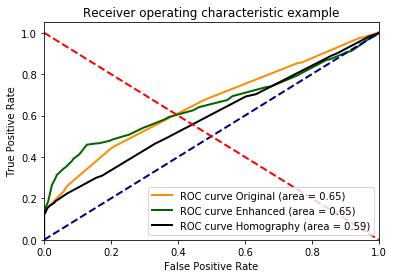

In [96]:
plt.figure()
lw = 2
plt.plot(fpr[i], tpr[i], color='darkorange', lw=lw, label='ROC curve Original (area = %0.2f)' % roc_auc[i])
plt.plot(fpr[j], tpr[j], color='darkgreen', lw=lw, label='ROC curve Enhanced (area = %0.2f)' % roc_auc[j])
plt.plot(fpr[k], tpr[k], color='black', lw=lw, label='ROC curve Homography (area = %0.2f)' % roc_auc[k])
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.plot([0, 1], [1, 0], color='red', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()
# plt.savefig(outPath+'ROC_DB2.png')
# plt.savefig(outPath+'ROC_DB3.png')
# plt.savefig(outPath+'ROC_DB4.png')

## calculate precision-recall curve

In [97]:
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import precision_recall_curve

# calculate precision-recall curve
precision_o, recall_o, thresholds_o = precision_recall_curve(y_test, y_score_orig)
precision_e, recall_e, thresholds_e = precision_recall_curve(y_test, y_score_enh)
precision_h, recall_h, thresholds_h = precision_recall_curve(y_test, y_score_homo)

# calculate precision-recall AUC
auc_orig = auc(recall_o, precision_o)
auc_enh = auc(recall_e, precision_e)
auc_homo = auc(recall_h, precision_h)

# calculate average precision score
ap_o = average_precision_score(y_test, y_score_orig)
ap_e = average_precision_score(y_test, y_score_enh)
ap_h = average_precision_score(y_test, y_score_homo)

auc Orig=0.313 ap_Orig=0.282
auc_Enh=0.364 ap_Enh=0.354
auc_Homo=0.276 ap_Homo=0.264


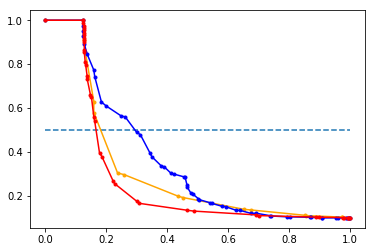

In [98]:
print('auc Orig=%.3f ap_Orig=%.3f' % (auc_orig, ap_o))
print('auc_Enh=%.3f ap_Enh=%.3f' % (auc_enh, ap_e))
print('auc_Homo=%.3f ap_Homo=%.3f' % (auc_homo, ap_h))

# plot no skill
plt.plot([0, 1], [0.5, 0.5], linestyle='--')
# plot the roc curve for the model
plt.plot(recall_o, precision_o, marker='.', color='orange')
plt.plot(recall_e, precision_e, marker='.', color='blue')
plt.plot(recall_h, precision_h, marker='.', color='red')
# show the plot
# plt.show()

# Save plot
plt.savefig(outPath+'Prec-Recall_DB4.png')

# Output details For Databse DB_2
# auc Orig=0.590 ap_Orig=0.564
# auc_Enh=0.687 ap_Enh=0.671
# auc_Homo=0.800 ap_Homo=0.794

## Test system for authentication and identification scenario's

Choose (at least) one of the databases provided and calculate the ROC (false match to false non match rate) for an authentication scenario and a Cumulative Match Characteristic (CMC) curve, which plots the rank (order in the candidate list) on the x-axis and the probability of identification at that or better rank on the y-axis.

This evaluation pipeline will be identical for the other biometric systems to be developed as assignments for this course.
Pay attention to the datastructure. Of course for the database you can calulate and store the features upfront before starting the validation procedures

References:
https://github.com/yoavalon/CMC-Curve/blob/master/CMC_scores.py
The relation between the ROC curve and the CMC https://ieeexplore.ieee.org/document/1544394#deqn1


## Pending Tasks
- Plot EER curve
- Plot CMC curve